# Self-Explaining Neural Networks
---

## Import libraries

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
from types import SimpleNamespace
from importlib import import_module

%matplotlib inline

In [2]:
from models.losses import *
from models.parameterizer import *
from models.conceptizer import *
from models.aggregator import *
from models.senn import SENN

In [3]:
from datasets.dataloaders import get_dataloader
from utils.plot_utils import show_explainations, show_concepts, plot_lambda_accuracy, get_comparison_plot

# Reproducing MNIST Results

## Configuration

In [4]:
plt.style.use('seaborn-notebook')

### Utility functions

In [5]:
def get_config(filename):
    config_path = Path('config')
    config_file = config_path / filename
    with open(config_file, 'r') as f:
        config = json.load(f)
    
    return SimpleNamespace(**config)

In [6]:
def load_checkpoint(config):
    model_file = Path('results') / config.exp_name / "checkpoints" / "best_model.pt" 
    return torch.load(model_file, config.device)

In [7]:
def accuracy(model, dataloader, config):
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for i, (x, labels) in enumerate(dataloader):
            x = x.float().to(config.device)
            labels = labels.long().to(config.device)
            y_pred, (concepts, relevances), _ = model(x)
            accuracy += (y_pred.argmax(axis=1) == labels).float().mean().item()
    print(f"Test Mean Accuracy: {(accuracy / (i+1))*100} %")

## Load MNIST Config

In [8]:
mnist_config = get_config("mnist_demo.json")

## Load MNIST Data

In [9]:
_, _, mnist_test_dl = get_dataloader(mnist_config)

## Load Trained Model

In [10]:
conceptizer = ConvConceptizer(**mnist_config.__dict__)
parameterizer = ConvParameterizer(**mnist_config.__dict__)
aggregator = SumAggregator(**mnist_config.__dict__)

mnist_SENN = SENN(conceptizer, parameterizer, aggregator)

### Load pre_trained

In [11]:
mnist_checkpoint = load_checkpoint(mnist_config)

mnist_SENN.load_state_dict(mnist_checkpoint['model_state'])

<All keys matched successfully>

## Report Accuracy

In [12]:
accuracy(mnist_SENN, mnist_test_dl, mnist_config)

Test Mean Accuracy: 87.92999994754791 %


## Result Visualization

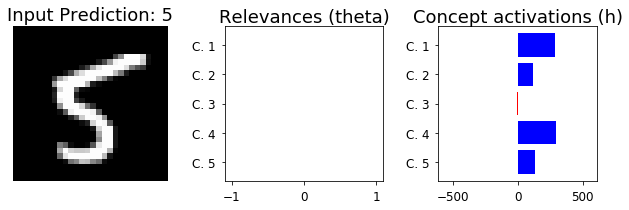

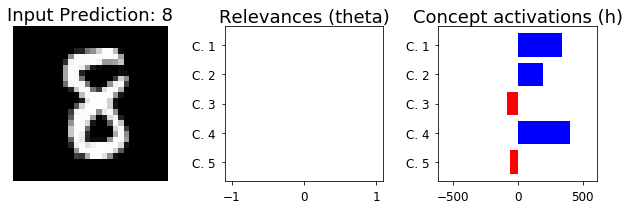

In [13]:
show_explainations(mnist_SENN, mnist_test_dl, 'mnist')

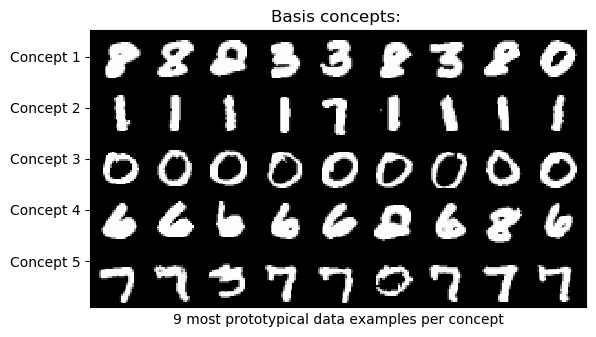

<Figure size 640x480 with 0 Axes>

In [14]:
show_concepts(mnist_SENN, mnist_test_dl, 'activation')

## Accuracy vs. Lambda 

In [42]:
config_list = ["lisa_master_l4_s29.json", "lisa_master_l3_s29.json", "lisa_master_l2_s29.json", "lisa_master_l1_s29.json", "lisa_master_l0_s29.json"]

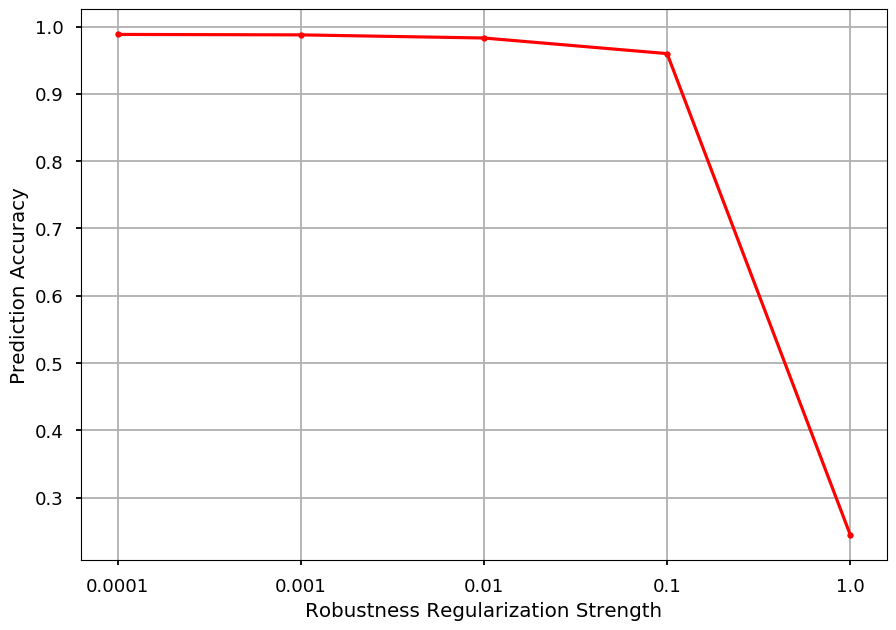

In [43]:
# NOTE: This will read the saved validation accuracies to speed up the process
# in the report we evaluate on the test set
_ = plot_lambda_accuracy(config_list, num_seeds=1, valid=True)

## Extension: Alternative Concept Representation

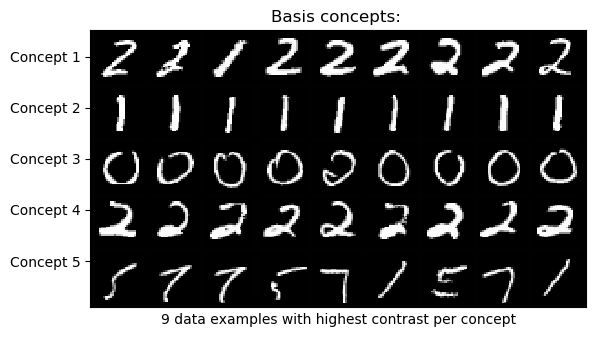

<Figure size 640x480 with 0 Axes>

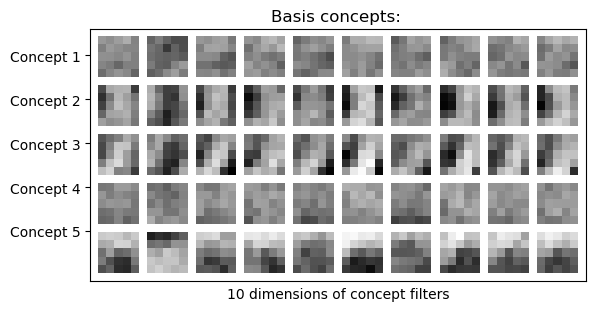

<Figure size 640x480 with 0 Axes>

In [15]:
show_concepts(mnist_SENN, mnist_test_dl, 'contrast')
show_concepts(mnist_SENN, mnist_test_dl, 'filter')

# Reproducing COMPAS Results

## Configuration

In [16]:
compas_config = get_config("compas_config.json")

## Load Test Data

In [17]:
_, _, compas_test_dl = get_dataloader(compas_config)

Finish preprocessing data..


## Load Trained Model

In [18]:
conceptizer = IdentityConceptizer(**compas_config.__dict__)
parameterizer = LinearParameterizer(**compas_config.__dict__)
aggregator = SumAggregator(**compas_config.__dict__)

compas_SENN = SENN(conceptizer, parameterizer, aggregator)

In [19]:
compas_checkpoint = load_checkpoint(compas_config)

compas_SENN.load_state_dict(compas_checkpoint['model_state'])

<All keys matched successfully>

## Test Performance

In [20]:
accuracy(compas_SENN, compas_test_dl, compas_config)

Test Mean Accuracy: 71.8999993801117 %


## Result Visualization

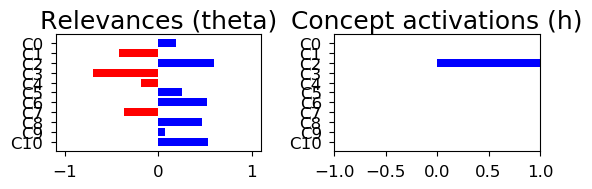

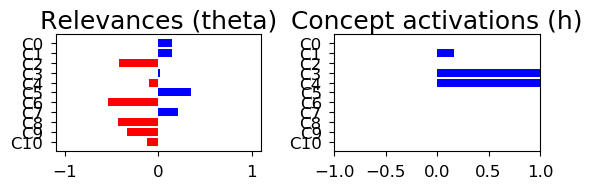

In [21]:
# show_explainations(compas_SENN, compas_test_dl, 'compas', concept_names=compas_config.concept_names)
show_explainations(compas_SENN, compas_test_dl, 'compas', concept_names=[f"C{i}" for i in range(11)])

## Accuracy vs. Lambda 

In [55]:
config_list = [["cl_4_s111.json","cl_4_s333.json","cl_4_s555.json"],
                        ["cl_3_s111.json","cl_3_s333.json","cl_3_s555.json"],
                        ["cl_2_s111.json","cl_2_s333.json","cl_2_s555.json"],
                        ["cl_1_s111.json","cl_1_s333.json","cl_1_s555.json"],
                        ["cl_0_s111.json","cl_0_s333.json","cl_0_s555.json"]]

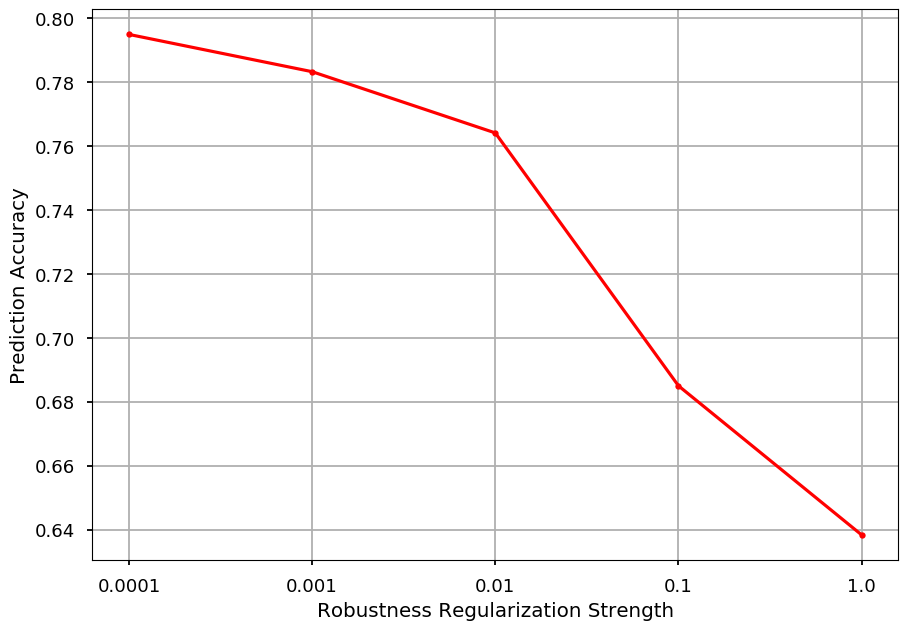

In [56]:
# NOTE: This will read the saved validation accuracies to speed up the process
# in the repoert we evaluate on the test set
_ = plot_lambda_accuracy(config_list, num_seeds=3, valid=True)

## Robustness Study

### Load pre-trained MNIST autoencoder

In [28]:
from utils.MNIST_autoencoder import AETrainer

ae_trainer = AETrainer(mnist_test_dl, batch_size=200)
ae_trainer.load_model("pretrained/autoencoder.pt")

### Get the latent vector for all the inputs from the test set

In [29]:
mnist_latents = ae_trainer.get_latent_reps(mnist_test_dl)

### Get the indices of the closest vectors

In [32]:
nearest_num = 5
query_index = 0

distances, indices = ae_trainer.get_most_similar(latents=mnist_latents,
                                                 query=mnist_latents[query_index],
                                                 number=nearest_num)

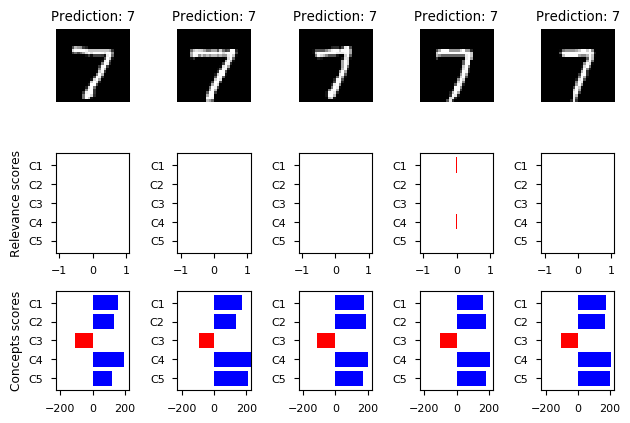

In [38]:
# prepare input images from the testloader 
test_images = torch.stack([mnist_test_dl.dataset[index][0] for index in indices[0]])

fig = get_comparison_plot(test_images, mnist_SENN)
fig.tight_layout()